# PIPELINE
1. Explore the data. 
2. Remove outliers, clean the data.
3. Get Data labels
3. Build the Trainloader.
4. Build the Model.
5. Train the Model.
6. Analyse model performance.
7. Save the model and add logs.

# [1] PRELIMINARY

In [95]:
# Making the code cells wider. Feel free to skip/disable.

from IPython.core.display import display, HTML
display(HTML('<style>/.container { width:97% !important; }</style>'))

In [122]:
'''IMPORTS'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchaudio import load
import torchaudio
import pickle
from sklearn.metrics import confusion_matrix

# Use GPU is available
device = torch.device("cuda:0")
torch.cuda.is_available()

False

- It is assumed that the code files are in the folder 'emotion'.
- Thus the five train folders should be in emotion/meld/train".
- Similarly for validation data.

In [3]:
'''SETTING ROOT DIRECTORIES'''

train_folder_path = "emotion/meld/train"
valid_folder_path = "emotion/meld/val"
emotion_list = np.array(["disgust", "fear", "happy", "neutral", "sad"])
emotion_labels = np.array(["DIS", "FEA", "HAP", "NEU", "SAD"])

We store the paths of all files in the training(and validation) set as numpy arrays. The dataloader then preprocesses them, and then they are fed into the Model for training. 

In [4]:
'''COLLECTING TRAIN FILE PATHS'''

train_paths = []

for emotion in emotion_list:
    folder_path = os.path.join(train_folder_path, emotion)
    
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        train_paths.append(file_path)

# Convert into numpy array.
train_paths = np.array(train_paths)

In [5]:
'''COLLECTING VALID FILE PATHS'''

valid_paths = []

for emotion in emotion_list:
    folder_path = os.path.join(valid_folder_path, emotion)
    
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        valid_paths.append(file_path)

# Convert into numpy array.
valid_paths = np.array(valid_paths)

In [6]:
print(len(train_paths))
print(len(valid_paths))

7354
830


Sort all the files in order to avoid different indices when dealing with outliers later.

In [ ]:
train_paths.sort()
valid_paths.sort()

# [2] EXPLORATORY DATA ANALYSIS

Plotting a sinlge audio waveform.

Shape of waveform: torch.Size([2, 64171])
Sample rate of waveform: 16000


[]

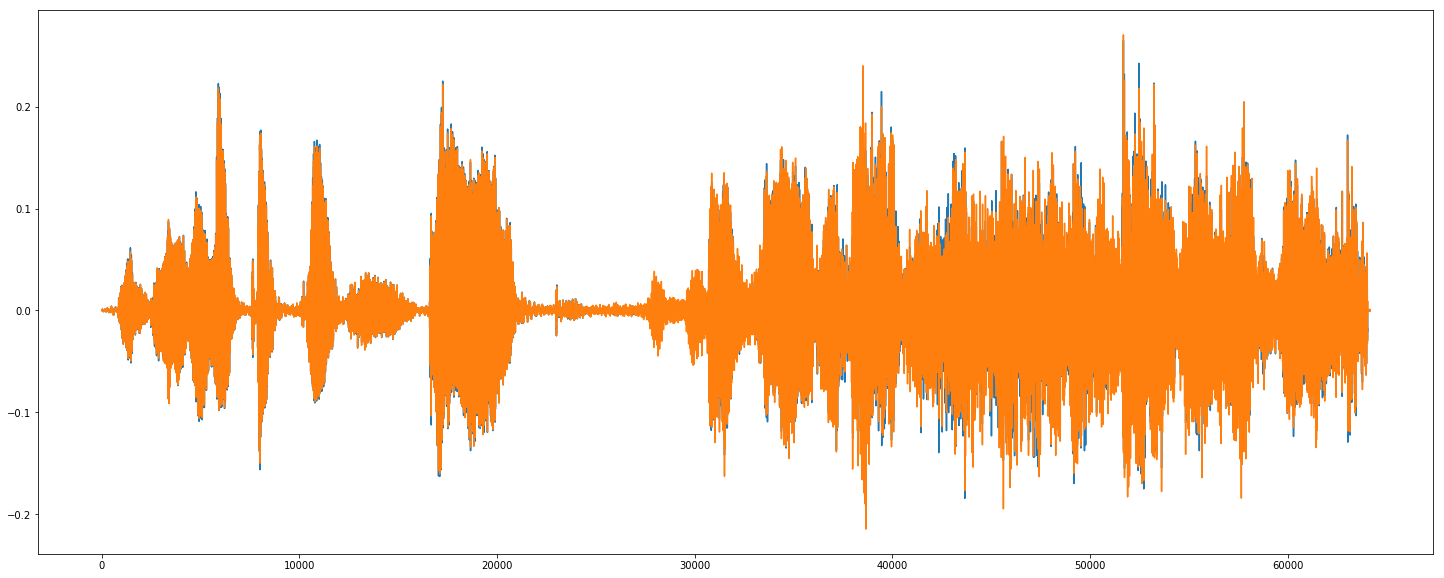

In [8]:
'''PLOTTING A SINGLE WAVEFORM'''

f = train_paths[0]
waveform, sample_rate = torchaudio.load(f)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure(figsize=[25,10])
plt.plot(waveform.t())
plt.plot()

Plotting multiple audio waveforms.

emotion/meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav
torch.Size([2, 64171])


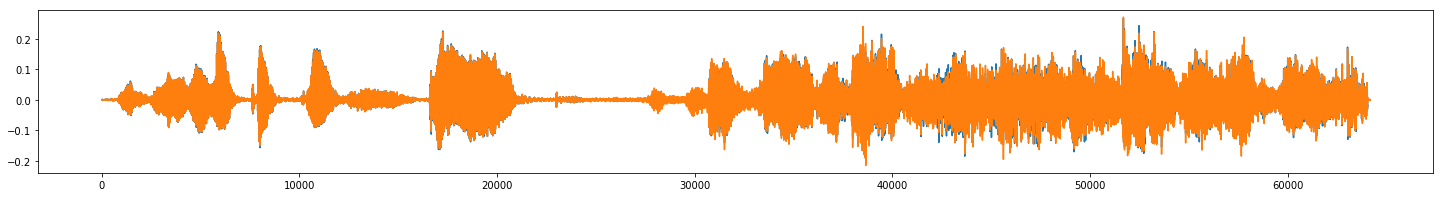

emotion/meld/train/disgust/MEL_dia1000_utt1_negative_DIS.wav
torch.Size([2, 92843])


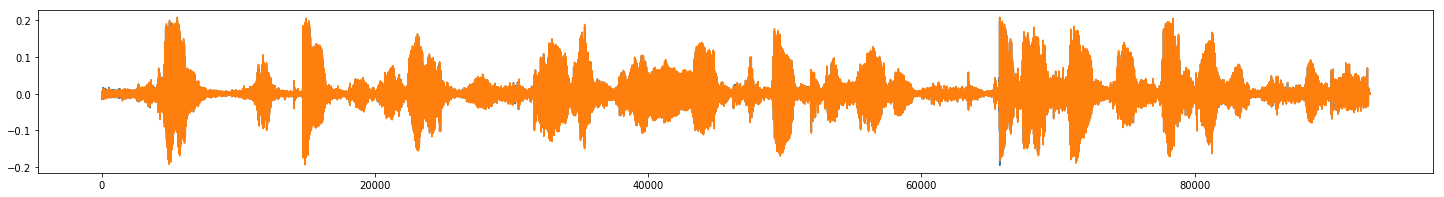

emotion/meld/train/disgust/MEL_dia1005_utt13_negative_DIS.wav
torch.Size([2, 9216])


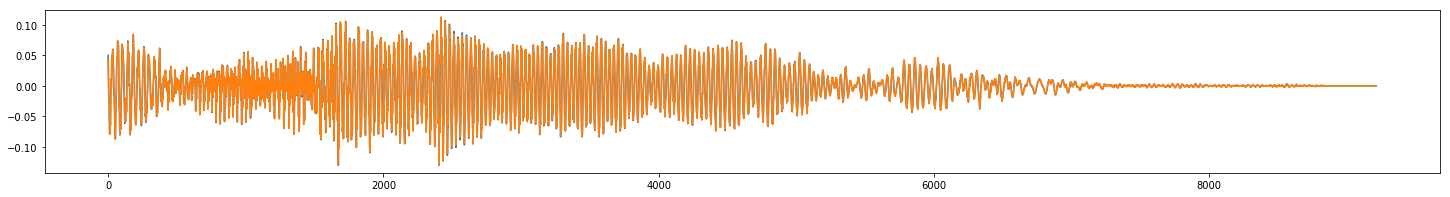

emotion/meld/train/disgust/MEL_dia1005_utt21_negative_DIS.wav
torch.Size([2, 57685])


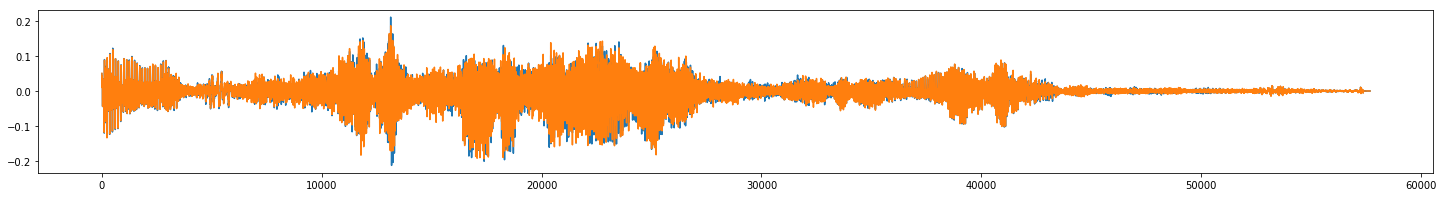

emotion/meld/train/disgust/MEL_dia1005_utt6_negative_DIS.wav
torch.Size([2, 28331])


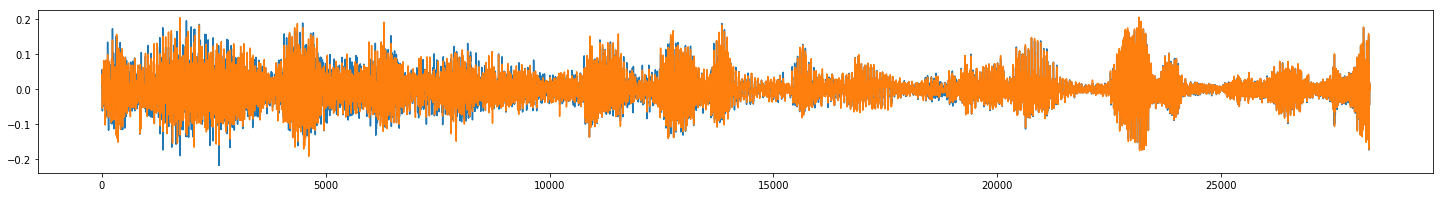

In [9]:
'''SAMPLE AUDIO FILES AND WAVEFORMS'''

from IPython.display import Audio, display

for i in range(5):
    # Load an audio file.
    t = load(train_paths[3*i])
    
    # Display information about it.
    print(train_paths[i])
    print(t[0].shape)
    
    # Display interactive output.
    display(Audio(train_paths[i]))
    
    # Plot the waveform.
    plt.figure(figsize=[25,3])
    plt.plot(t[0].t())
    plt.show()

OBSERVATIONS :
- Length of files/waveforms are variable.
- Audio may contain multiple speakers.
- Audio may contain backgound noise (laughter).

# [3] REMOVING OUTLIERS

- We calculate the Mel-frequency cepstrum coefficients for the whole training set, so that we can identify outliers and decide how skewed the training data. 
- We need to determine an efficient representation for the data so that we can feed it into the network. To do this, we need to deal with variable sized input sequences. 
- We start by analysing the extent of variation in input size. 
- As we will be using mfcc to represent the data, we carry out out analysis and outlier detection using mfcc's as well.

In [27]:
mfcc = torchaudio.transforms.MFCC()
ws = []
ceps = []

for file_path in tqdm(train_paths):
    w,sr = load(file_path)
    image_ceps = mfcc(w)    
    ws.append(w.shape[1])
    ceps.append(image_ceps.shape[2])

100%|██████████| 7354/7354 [00:41<00:00, 177.05it/s]


In [28]:
ws = np.asarray(ws)
ceps = np.array(ceps)

In [31]:
print(np.max(ws))
print(np.min(ws))

3761152
1024


In [32]:
print(np.max(ceps))
print(np.min(ceps))

18806
6


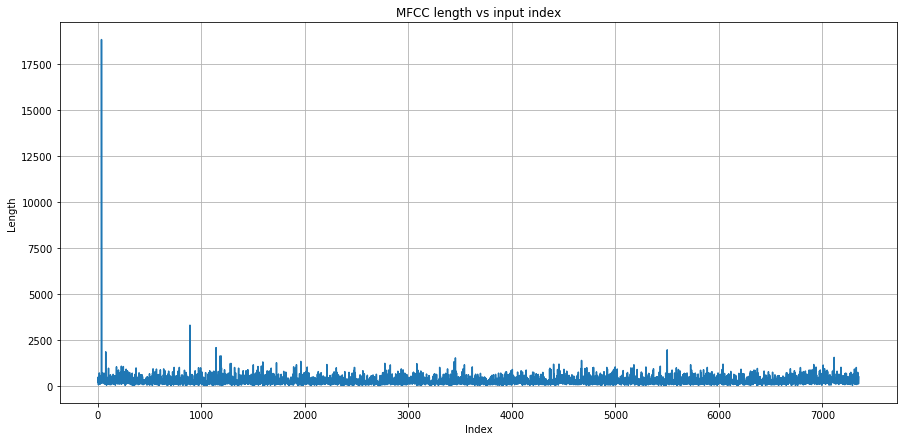

In [34]:
plt.figure(figsize=[15,7])
plt.plot(ceps, '-')
plt.grid()
plt.title("MFCC length vs input index")
plt.ylabel("Length")
plt.xlabel("Index")
plt.show()

We plot the mfcc size vs index graph to identify the severity of outliers.

- As we can see in the above graph, some audio files are too long.  
- We would either have to skip these files, or crop them into the maximum size we can accomodate.

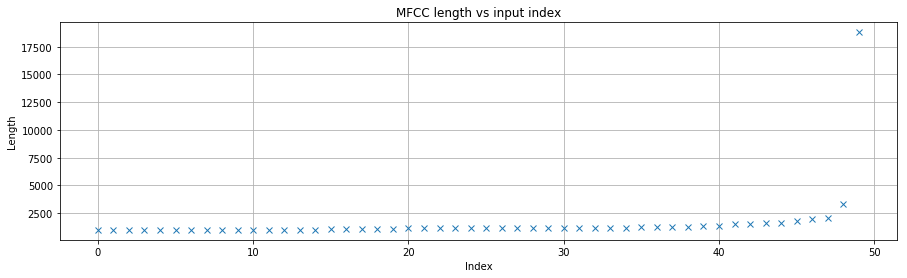

In [96]:
cepss = np.array(ceps)
cepss.sort()

plt.figure(figsize=[15,4])
plt.plot(cepss[-50:], 'x')
plt.grid()
plt.title("MFCC length vs input index")
plt.ylabel("Length")
plt.xlabel("Index")
plt.show()

Next we plot the fifty biggest files in the training set, in increasing order of sizes. We skip 9 of these training files removing them from out training set. 

In [37]:
skip_indices = ceps.argsort()[-9:]
print(skip_indices)

# skip_indices = [3455, 7115, 1180, 1191, 76, 5502, 1142, 890, 35]

[3455 7115 1180 1191   76 5502 1142  890   35]


We remove the skip indices from the set of training paths, to obtain a cleaner training set. We let the validation set reamin as is.

In [38]:
train_paths_c = np.delete(train_paths, skip_indices, axis=0)
valid_paths_c = valid_paths

We plot the mfcc lengths again as a sanity check to see if our data is balanced now. To do that we first calculate the mfcc on the new training paths.

In [49]:
mfcc2 = torchaudio.transforms.MFCC()
ceps2 = []

for file_path in tqdm(train_paths_c):
    w2,sr2 = load(file_path)
    image_ceps2 = mfcc2(w2)
    ceps2.append(image_ceps2.shape[2])
    

100%|██████████| 7345/7345 [00:41<00:00, 177.84it/s]


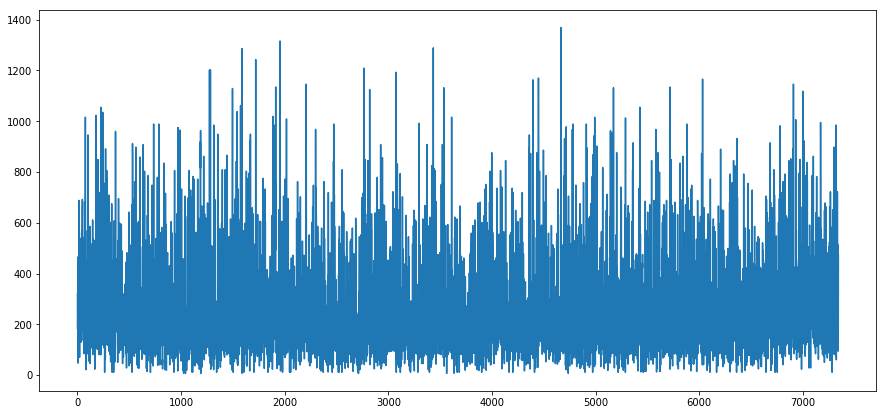

In [59]:
plt.figure(figsize=[15,7])
plt.plot(ceps2)
plt.show()

The data looks more uniform now. 

We plot a graph to see the distribution of mfcc lengths in our now 'clean' dataset.

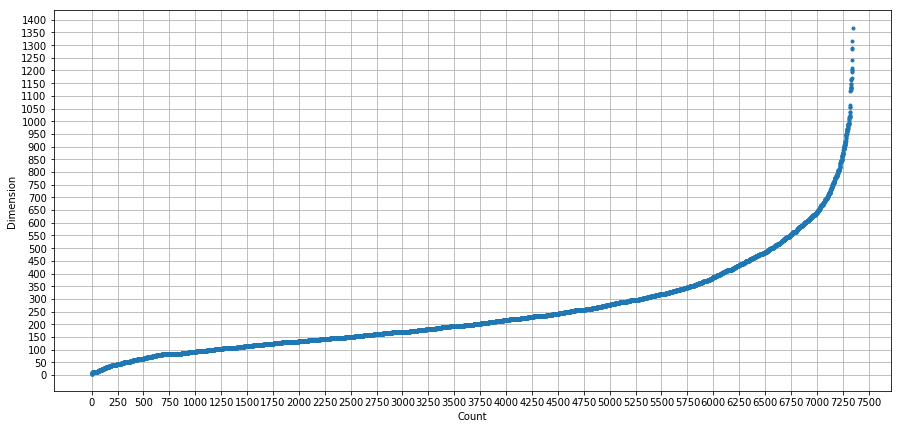

In [60]:
ceps2s = np.array(ceps2)
ceps2s.sort()

plt.figure(figsize=[15,7])
plt.plot(ceps2s, '.')
plt.grid()
plt.xticks(np.arange(0,7501,250))
plt.yticks(np.arange(0,1401,50))
plt.ylabel("Dimension")
plt.xlabel("Count")
plt.show()

We set the max dimension, `dim` to 1376. This is the value to which we will pad all our inputs. 

In [140]:
# dim = max(ceps2)
# dim = 1369
dim = 1376
dim

1376

# [4] DATA LABELS

Now after cleaning the data, and the removing outliers, we procedd to obtain the training and validation labels for out data.

In [98]:
'''OBTAIN TRAINING LABELS'''

train_labels_c = []

for path in train_paths_c:
    label = path.split('_')[-1].split('.')[0]
    loc = np.where(emotion_labels == label)[0][0]
    train_labels_c.append(loc)
    
train_labels_c = np.asarray(train_labels_c)
print(train_labels_c.shape)

(7345,)


In [141]:
'''OBTAIN VALIDATION LABELS'''

valid_labels_c = []

for path in valid_paths_c:
    label = path.split('_')[-1].split('.')[0]
    loc = np.where(emotion_labels == label)[0][0]
    valid_labels_c.append(loc)
    
valid_labels_c = np.asarray(valid_labels_c)
print(valid_labels_c.shape)

(830,)


# [5] CLASS ANALYSIS

In [67]:
'''GET NUMBER OF EXAMPLES PER CLASS : TRAINING SET'''

_, train_class_count = np.unique(train_labels_c, return_counts=True)
train_class_count

array([ 230,  216, 1605, 4590,  704])

In [68]:
'''GET NUMBER OF EXAMPLES PER CLASS : VALIDATION SET'''

_, valid_class_count = np.unique(valid_labels_c, return_counts=True)
valid_class_count

array([ 28,  25, 181, 517,  79])

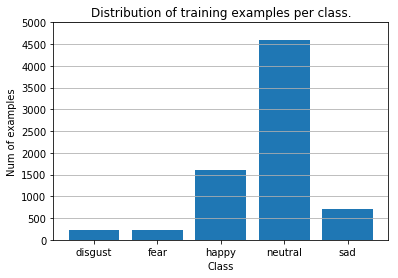

In [75]:
'''TRAINING CLASS ANALYSIS'''

plt.bar(emotion_list, train_class_count, )
plt.grid(axis='y')
plt.yticks(np.arange(0,5001,500))
plt.ylabel('Num of examples')
plt.xlabel('Class')
plt.title('Distribution of training examples per class.')
plt.show()

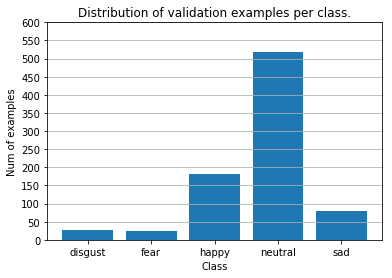

In [78]:
'''VALIDATION CLASS ANALYSIS'''

plt.bar(emotion_list, valid_class_count, )
plt.grid(axis='y')
plt.yticks(np.arange(0,601,50))
plt.ylabel('Num of examples')
plt.xlabel('Class')
plt.title('Distribution of validation examples per class.')
plt.show()

OBSERVATIONS :
- The training and test set come from the same distribution.
- As such the prior probablity of a sample for each class is proportion to the above class frequencies.
- Another observation is that the classes are skewed.
- We would have to pass weights to our loss function otherwise it would always predict the label `neutral`. We calculate these weights later.

# [6] PREPARING THE DATA

In [101]:
def pad(image, max_width, detach=True):
    '''
    - Pad an image to the width `max_width`.
    - It is expected that the image's third dimension is smaller than `max_width`.
    '''
    
    if(detach): img = image.detach().numpy()
    cur = image.shape[2]
    req = dim - cur
    return np.pad(img,((0,0),(0,0),(0,req)), 'constant')

# Try to pad a random image.
pad(image_ceps2, dim).shape

(2, 40, 1376)

In [102]:
# Set the sample rate
sample_rate = 16000

In [103]:
'''CREATING CUSTOM DATASET CLASS'''

class EmotionDataset():
    
    def __init__(self, mode, transform=None):

        self.mode = mode
        self.transform = transform
        self.mfcc = torchaudio.transforms.MFCC(sample_rate)
            
    def __getitem__(self, idx):
        
        if self.mode == "train":
            file_path, target = train_paths_c[idx], train_labels_c[idx]
        
        if self.mode == "valid":
            file_path, target = valid_paths_c[idx], valid_labels_c[idx]
            
        if self.mode == "test":
            file_path = test_paths_c[idx]
                
                
        # Load the data from the above paths.
        data,sr = load(file_path)
        
        # Calculate the mfcc's.
        data = self.mfcc(data)
        
        # Crop the data.
        data = data[:,:,:dim]
        
        # Pad the data.
        data = pad(data, dim)
        
        if self.mode == "test":
            return data
        else:
            return data, target
    
    
    def __len__(self):
        if self.mode == "train":
            return len(train_paths_c)
        
        if self.mode == "valid":
            return len(valid_paths_c)
        
        if self.mode == "test":
            return len(test_paths_c)

In [104]:
'''LOADING DATASET'''

train_dataset = EmotionDataset(mode="train", transform = transforms.ToTensor())
valid_dataset = EmotionDataset(mode="valid", transform = transforms.ToTensor())

In [88]:
'''MAKING DATASET ITERABLE'''

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)#

# [7] BUILDING THE MODEL

In [106]:
def padding_help(input_dim, kernel_size, stride, padding, pool_dim):
    '''
    Function to calculate kernel sizes for CNN.
    Does not affect the model.
    '''
    
    input_dim = np.asarray(input_dim)
    kernel_size = np.asarray(kernel_size)
    stride = np.asarray(stride)
    padding = np.asarray(padding)
    pool_dim = np.asarray(pool_dim)
    output_dim = (input_dim - kernel_size + 2 * padding)/stride + 1
    pool_dim = output_dim / pool_dim
    print(input_dim, '\t--->', output_dim, '\t--->', pool_dim)

In [107]:
padding_help([40,1376], kernel_size=[3,3], stride=[1,1], padding=[1,1], pool_dim=[2,2])
padding_help([20,688], kernel_size=[3,3], stride=[1,1], padding=[1,1], pool_dim=[2,2])
padding_help([10,344], kernel_size=[3,3], stride=[1,1], padding=[1,1], pool_dim=[2,2])
padding_help([5,172], kernel_size=[3,3], stride=[1,1], padding=[1,1], pool_dim=[1,2])
padding_help([5,86], kernel_size=[3,3], stride=[1,1], padding=[1,1], pool_dim=[1,2])

[  40 1376] 	---> [  40. 1376.] 	---> [ 20. 688.]
[ 20 688] 	---> [ 20. 688.] 	---> [ 10. 344.]
[ 10 344] 	---> [ 10. 344.] 	---> [  5. 172.]
[  5 172] 	---> [  5. 172.] 	---> [ 5. 86.]
[ 5 86] 	---> [ 5. 86.] 	---> [ 5. 43.]


In [ ]:
'''CREATEING MODEL CLASS'''

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # (2, 40, 1376) -> (8,20,688)
        self.cnn1 = nn.Conv2d(2, 8, kernel_size=[3,3], stride=[1,1], padding=[1,1])
        self.relu1 = nn.ReLU() 
        self.bn1 = nn.BatchNorm2d(8)
        self.maxpool1 = nn.MaxPool2d(kernel_size=[2,2], padding=[0,0])
#         self.dropout1 = nn.modules.Dropout2d(p=0.3)
        
        # (8,20,688) -> (16,10,344)
        self.cnn2 = nn.Conv2d(8, 16, kernel_size=[3,3], stride=[1,1], padding=[1,1])
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=[2,2], padding=[0,0])
#         self.dropout2 = nn.modules.Dropout2d(p=0.2)
        
        # (16,10,344) -> (32,5,172)
        self.cnn3 = nn.Conv2d(16, 32, kernel_size=[3,3], stride=[1,1], padding=[1,1])
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        self.maxpool3 = nn.MaxPool2d(kernel_size=[2,2], padding=[0,0])
#         self.dropout3 = nn.modules.Dropout2d(p=0.2)
        
        # (32,5,172) -> (64,5,86)
        self.cnn4 = nn.Conv2d(32, 64, kernel_size=[3,3], stride=[1,1], padding=[1,1])
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool4 = nn.MaxPool2d(kernel_size=[1,2], padding=[0,0])
#         self.dropout4 = nn.modules.Dropout2d(p=0.2)
        
        # (64,5,86) -> (64,5,43)
        self.cnn5 = nn.Conv2d(64, 64, kernel_size=[3,3], stride=[1,1], padding=[1,1])
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(64)
        self.maxpool5 = nn.MaxPool2d(kernel_size=[1,2], padding=[0,0])
#         self.dropout5 = nn.modules.Dropout2d(p=0.2)
    
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(64*5*43, 1024)
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm1d(1024)
        self.droupout6 = nn.modules.Dropout(p=0.3)
        
        self.linear2 = nn.Linear(1024, 128)
        self.relu7 = nn.ReLU()
        self.bn7 = nn.BatchNorm1d(128)
        self.droupout7 = nn.modules.Dropout(p=0.3)
        
        self.linear3 = nn.Linear(128, 5)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
#         print(x.shape)
        
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.bn1(out)
        out = self.maxpool1(out)
#         out = self.dropout1(out)
#         print(out.shape)
        
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        out = self.maxpool2(out)
#         out = self.dropout2(out)
#         print(out.shape)
        
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.bn3(out)
        out = self.maxpool3(out)
#         out = self.dropout3(out)
#         print(out.shape)

        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.bn4(out)
        out = self.maxpool4(out)
#         out = self.dropout4(out)
#         print(out.shape)

        out = self.cnn5(out)
        out = self.relu5(out)
        out = self.bn5(out)
        out = self.maxpool5(out)
#         out = self.dropout5(out)
#         print(out.shape)
        
        out = self.flatten(out)
#         print(out.shape)
        
        out = self.linear1(out)
        out = self.relu6(out)
        out = self.bn6(out)
        out = self.droupout6(out)
#         print(out.shape)
    
        out = self.linear2(out)
        out = self.relu7(out)
        out = self.bn7(out)
        out = self.droupout7(out)
#         print(out.shape)
        
        out = self.linear3(out)
        out = self.softmax(out)
#         print(out.shape)
        
        return out

# [8] SETTING MODEL PARAMETERS

In [109]:
'''INSTANTIATING MODEL CLASS'''

model = Model()

if torch.cuda.is_available():
    model.to(device)

In [111]:
'''OBTAINING MODEL WEIGHTS'''

weights = np.array(train_class_count)
weights = 1 / weights
weights = weights / np.sum(weights)
weights = torch.FloatTensor(weights)
print(weights)

tensor([0.3869, 0.4119, 0.0554, 0.0194, 0.1264])


In [112]:
'''INSTANTIATING LOSS CLASS'''

if torch.cuda.is_available():
    weights.to(device)

criterion = nn.CrossEntropyLoss(weight = weights)

In [113]:
'''INSTANTIATING OPTIMIZER CLASS'''

learning_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [114]:
'''INITIALIZING SOME VARIABLES'''

iterr = 0

iter_list = []
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# [9] TRAINING THE MODEL

In [117]:
'''SETTING CUSTOM PARAMETERS'''

inspect_size = 10
num_epochs = 5
n_iters = int((len(train_paths_c) / batch_size) * num_epochs)

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False, precision=4)

print("Number of Iterations     :", n_iters)
print("Number of Epochs         :", num_epochs)
print("Number of Sample-Points  :", int(n_iters/inspect_size))
print(batch_size)

Number of Iterations     : 286
Number of Epochs         : 5
Number of Sample-Points  : 28
128


In [118]:
insepct_size = 1

- Note that training time of the model is highly dependent on the CPU preformance. 
- Due to heavy pre-processing, the model train time is limited by the CPU. For reference, one epoch takes about 30 seconds on an 8 core intel i7 8700k processor, with a nvidia 1080Ti.
- The train time can be reduced by calculating and storing the mfcc's once and then using them for all later epochs. 
- Curently we re-calculate the mfcc's for each epoch.

In [ ]:
'''TRAINING THE MODEL'''

# import time
# time_begin = time.asctime()
init_iters = iterr
from tqdm import tqdm_notebook as tqdm

for epoch in range(num_epochs):
    print('====================================================================================================')
    print("Epoch : {:3.0f}".format(epoch))
        
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        
        if torch.cuda.is_available():
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        optimizer.zero_grad()
        model.train()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
                
        iterr += 1
        
        if iterr % inspect_size == 0:
            iter_list.append(iterr)

            print("Iteration : {:.0f}/{:.0f} [{:2.0f}%] ".format(iterr - init_iters,n_iters, 100*(iterr - init_iters)/n_iters))
        # --------------------------------------------------------------------------------------------------------
        # Calculating train accuracy
            temp, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            
            labels = labels.int()
            predicted = predicted.int()
            
            if torch.cuda.is_available():
                correct = (predicted.cpu() == labels.cpu()).sum()
            else:
                correct = (predicted == labels).sum()
                                                          
            accuracy = 100 * correct.item() / total            

            train_loss_list.append(loss.item())
            train_acc_list.append(accuracy)

            print('[Train]\t Loss: {:.2f}\t Accuracy: {:.2f}'.format(loss.item(), accuracy))
        # --------------------------------------------------------------------------------------------------------
        # Calculating test accuracy
            correct = 0
            total = 0                  
                
            images, labels = next(iter(valid_loader))    

            if torch.cuda.is_available():
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
            else:
                images = Variable(images)
                labels = Variable(labels)

            model.eval()
            outputs = model(images)
#             outputs = outputs.float()
#             labels = labels.float()
#             print(outputs)
#             print(labels)
            
            loss = criterion(outputs, labels)

            temp, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            predicted = predicted.float()

            if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum()
            else:
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct.item() / total
            
            test_loss_list.append(loss.item())
            test_acc_list.append(accuracy)
            
            print('[Test ]\t Loss: {:.2f}\t Accuracy: {:.2f}'.format(loss.item(), accuracy))
        # --------------------------------------------------------------------------------------------------------
            print('=========================================================')
# time_end = time.asctime()

# [10] TRAINING ANALYSIS

In [135]:
# model_no = 100

In [ ]:
'''CONFUSION MATRIX'''

confusion_matrix(labels.cpu(), predicted.cpu())

In [137]:
'''GENERATING AVERAGE INSPECTION LISTS'''

os.makedirs('Graphs', exist_ok=True)

# Defining roll function
def make_roll(input_list, roll_size=5):
    output_list = []
    
    for i in range(len(input_list)):
        if i==0:
            output_list.append(input_list[0])
        elif i<roll_size:
            output_list.append(np.mean(input_list[:i+1]))
        else:
            output_list.append(np.mean(input_list[i-roll_size:i]))
    return output_list

# Generating roll lists
train_roll_loss_list = make_roll(train_loss_list, roll_size=30) 
train_roll_acc_list = make_roll(train_acc_list, roll_size=30)  

test_roll_acc_list = make_roll(test_acc_list, roll_size=30)  
test_roll_loss_list = make_roll(test_loss_list, roll_size=30)  

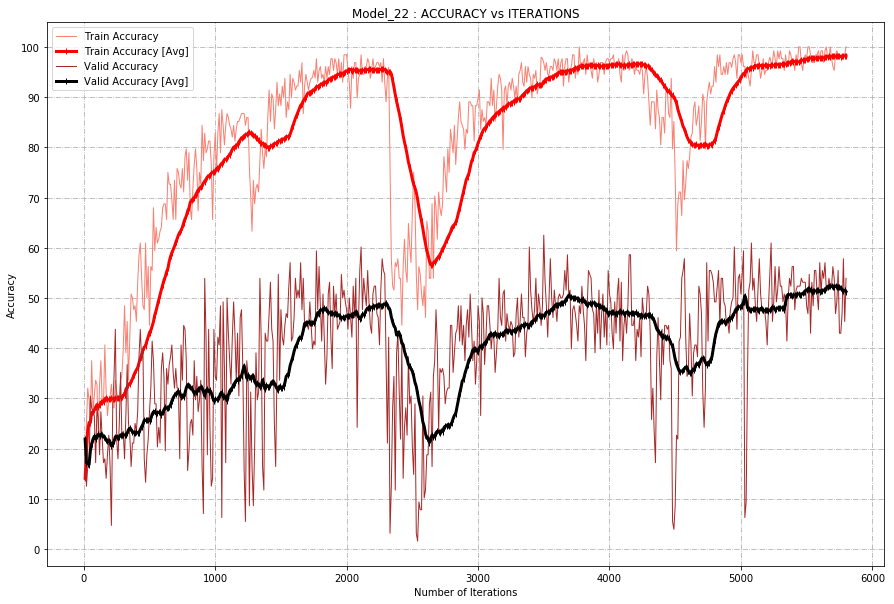

In [138]:
'''PLOTTTING THE ACCURACY GRAPH'''

plt.figure(figsize=[15,10])

plt.plot(iter_list, train_acc_list, '-', lw=1, c='salmon', label='Train Accuracy')
plt.plot(iter_list, train_roll_acc_list, '-|r', lw=3, label='Train Accuracy [Avg]')

plt.plot(iter_list, test_acc_list, '-', lw=1, c='brown', label='Valid Accuracy')
plt.plot(iter_list, test_roll_acc_list, '-|k', lw=3, label='Valid Accuracy [Avg]')

plt.title('Model_{} : ACCURACY vs ITERATIONS'.format(model_no))

plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')

plt.yticks(np.arange(0,101,10))

plt.grid(True, linestyle='-.',)
plt.tick_params(labelcolor='k')

plt.legend()
plt.savefig("Graphs/model{}_iterr={}_acc.png".format(model_no, iterr), dpi=100)
plt.show()

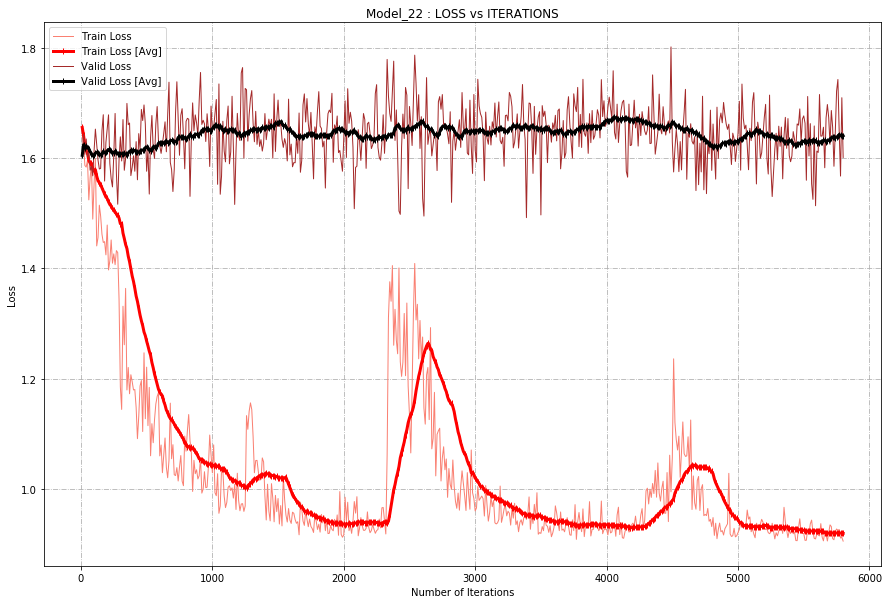

In [139]:
'''PLOTTTING THE LOSS GRAPH'''

plt.figure(figsize=[15,10])

plt.plot(iter_list, train_loss_list, '-', lw=1, c='salmon', label='Train Loss')
plt.plot(iter_list, train_roll_loss_list, '-|r', lw=3, label='Train Loss [Avg]')

plt.plot(iter_list, test_loss_list, '-', lw=1, c='brown', label='Valid Loss')
plt.plot(iter_list, test_roll_loss_list, '-|k', lw=3, label='Valid Loss [Avg]')

plt.title('Model_{} : LOSS vs ITERATIONS'.format(model_no))
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')

plt.grid(True, linestyle='-.',)
plt.tick_params()
plt.legend()
plt.savefig("Graphs/model{}_iterr={}_loss.png".format(model_no, iterr), dpi=100)
plt.show()

# [11] LOGGING

In [142]:
# num_epochs = 105

print("model_no = ", model_no )
print("batch_size = ", batch_size)
print("learning_rate = ", learning_rate)
print("num_epochs = ", num_epochs)
print("num_iters = ", iterr)
print("inspect_size = ", inspect_size)
print("num_samples = ", int(n_iters/inspect_size))

print("best_train_loss = ", min(train_loss_list))
print("best_train_acc = ", max(train_acc_list))
print("best_valid_loss = ", min(test_loss_list))
print("best_valid_acc = ", max(test_acc_list))

print(model)
print(optimizer)
print(criterion)

model_no =  22
batch_size =  128
learning_rate =  0.0003
num_epochs =  5
num_iters =  5800
inspect_size =  10
num_samples =  28
best_train_loss =  0.904907763004303
best_train_acc =  100.0
best_valid_loss =  1.4923150539398193
best_valid_acc =  62.5
Model(
  (cnn1): Conv2d(2, 8, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 16, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (cnn3): Conv2d(16, 32, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
'''PICKLING RESULTS'''

os.makedirs('Models', exist_ok=True)

### EVALUATION PARAMETERS ###
# Useful in plotting and analysing graphs 

mdict = {}
list_name = ['iter_list', 'train_loss_list', 'train_acc_list', 'test_loss_list', 'test_acc_list', 'iterr']
# list_name = ['iter_list', 'train_loss_list', 'train_acc_list', 'iterr']
for i in range(len(list_name)):
    mdict[list_name[i]] = eval(list_name[i])  

fileObject = open('Models/model{}_iterr={}_inspect.pkl'.format(model_no, iterr),'wb')
pickle.dump(mdict,fileObject)   
fileObject.close()

### MODEL PARAMETERS ###
# Useful in further training the model
msd = model.state_dict()
fileObject = open('Models/model{}_iterr={}_state_dict.pkl'.format(model_no, iterr),'wb')
pickle.dump(msd,fileObject)   
fileObject.close()

In [133]:
'''RESTORING PICKLED RESULTS'''

model_no = 22
iterr = 5800

### EVALUATION PARAMETERS ###
fileObject = open('Models/model{}_iterr={}_inspect.pkl'.format(model_no, iterr),'rb')
mdictx = pickle.load(fileObject)  

iter_list = mdictx['iter_list']
train_loss_list = mdictx['train_loss_list']
train_acc_list = mdictx['train_acc_list']
test_loss_list = mdictx['test_loss_list']
test_acc_list = mdictx['test_acc_list']
iterr = mdictx['iterr']

### MODEL PARAMETERS ###

# fileObject = open('Models/model{}_iterr={}_state_dict.pkl'.format(model_no, iterr),'rb')
# msd = pickle.load(fileObject) 
# model.load_state_dict(state_dict = msd)

# model.load_state_dict(torch.load('Models/model{}_iterr={}_state_dict.pkl'.format(model_no, iterr)))



# [12] SAVING WEIGHTS

In [ ]:
'''SAVING WEIGHTS'''

torch.save(the_model.state_dict(), 'Weights/model{}_iterr={}_state_dict.pt'.format(model_no, iterr))

In [ ]:
'''LOADING WEIGHTS'''

# Assuming loading weights on a cpu.

model.load_state_dict(torch.load('Weights/model{}_iterr={}_state_dict.pt'.format(model_no, iterr), 
                                    map_location=torch.device('cpu')))

Links for Graphs and Saved Model Parameters:
- Link to models : https://drive.google.com/open?id=1w12aKqDjJR0KkLq-XDHVi604gMYuHMCc 
- Link to graphs : https://drive.google.com/drive/folders/1w12aKqDjJR0KkLq-XDHVi604gMYuHMCc?usp=sharing